In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf

In [2]:
path = r"C:\Users\rokzc\jupyter\Water Bodies Dataset"

data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (256, 256), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [3]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 256, 256, 3) (5682,)


In [4]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 256, 256, 3) (2841, 256, 256, 3)


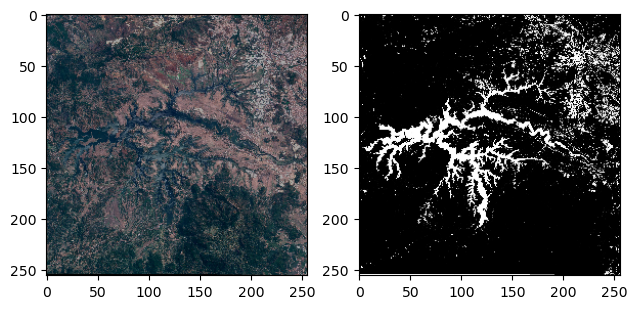

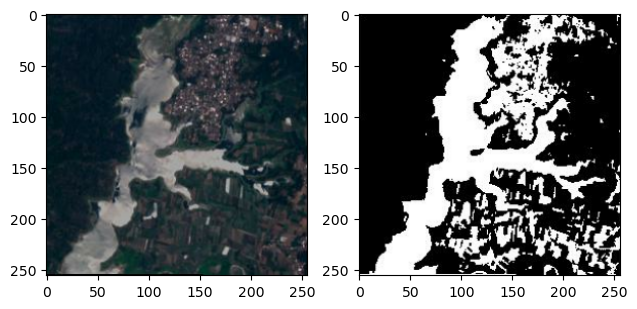

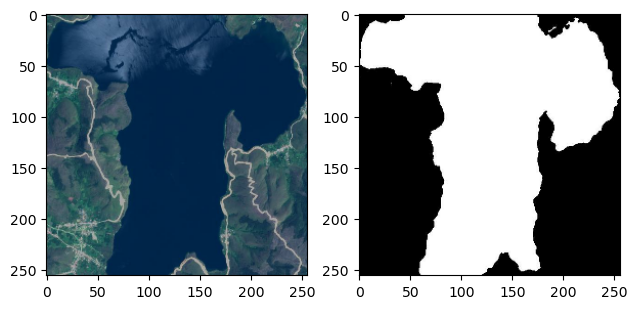

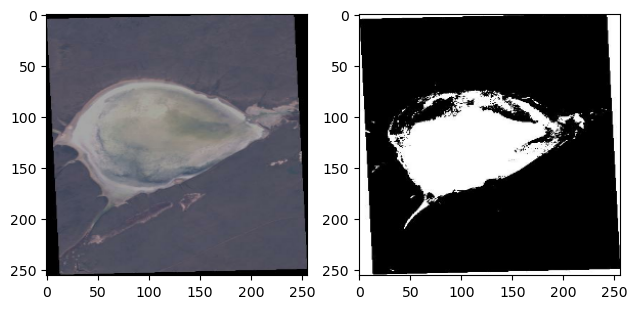

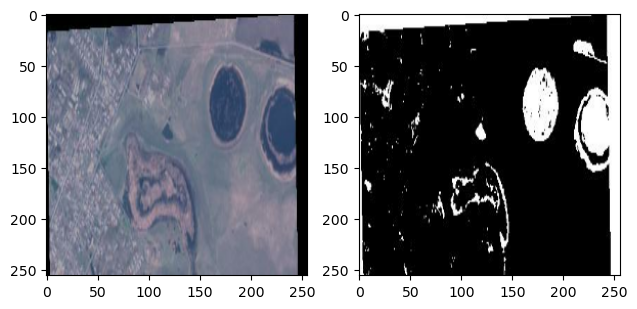

In [5]:
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])
    
    plt.subplot(1, 2, 2)
    plt.imshow(masks[i])
    
    plt.tight_layout()
    plt.show()

In [6]:
X = np.zeros(shape = images.shape[:-1] + (1, ))
y = np.zeros(shape = masks.shape[:-1] + (1, ))

for i in range(X.shape[0]):
    X[i] = tf.image.rgb_to_grayscale(images[i])
    y[i] = tf.image.rgb_to_grayscale(masks[i])
    
print(X.shape, y.shape)

(2841, 256, 256, 1) (2841, 256, 256, 1)


In [7]:
X = X / 255.0
y = y / 255.0

In [8]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 256, 256, 1) (569, 256, 256, 1)


In [9]:
def encoder_block(inputs, num_filters): 
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(inputs) 
    x = tf.keras.layers.Activation('elu')(x)  
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x) 
    x = tf.keras.layers.Activation('elu')(x) 
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x) 
    return x

def decoder_block(inputs, skip_features, num_filters): 
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs) 
    skip_features = tf.image.resize(skip_features, size = (x.shape[1], x.shape[2])) 
    x = tf.keras.layers.Concatenate()([x, skip_features]) 
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x) 
    x = tf.keras.layers.Activation('elu')(x) 
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x) 
    x = tf.keras.layers.Activation('elu')(x) 
    return x

In [10]:
def unet_model(input_shape = (128, 128, 1), num_classes = 1): 
    inputs = tf.keras.layers.Input(shape = input_shape) 

    s1 = encoder_block(inputs, 50) 
    s2 = encoder_block(s1, 100) 
    s3 = encoder_block(s2, 150) 
    s4 = encoder_block(s3, 200) 

    b1 = tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(s4) 
    b1 = tf.keras.layers.Activation('elu')(b1) 
    b1 = tf.keras.layers.Conv2D(filters = 100, kernel_size = (3, 3), padding = "same", kernel_initializer = "he_uniform")(b1) 
    b1 = tf.keras.layers.Activation('elu')(b1) 

    s5 = decoder_block(b1, s4, 200) 
    s6 = decoder_block(s5, s3, 150) 
    s7 = decoder_block(s6, s2, 100) 
    s8 = decoder_block(s7, s1, 50) 

    outputs = tf.keras.layers.Conv2D(filters = num_classes, kernel_size = (1, 1), padding = "same", activation = "sigmoid")(s8) 

    model = tf.keras.models.Model(inputs = [inputs], outputs = [outputs], name = 'U-Net') 
    return model 

In [11]:
model = unet_model(input_shape = (256, 256, 1), num_classes = 1) 

model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 50  500         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 activation (Activation)        (None, 256, 256, 50  0           ['conv2d[0][0]']                 
                                )                                                             

                                                                                                  
 concatenate_1 (Concatenate)    (None, 64, 64, 300)  0           ['conv2d_transpose_1[0][0]',     
                                                                  'tf.image.resize_1[0][0]']      
                                                                                                  
 conv2d_12 (Conv2D)             (None, 64, 64, 150)  405150      ['concatenate_1[0][0]']          
                                                                                                  
 activation_12 (Activation)     (None, 64, 64, 150)  0           ['conv2d_12[0][0]']              
                                                                                                  
 conv2d_13 (Conv2D)             (None, 64, 64, 150)  202650      ['activation_12[0][0]']          
                                                                                                  
 activatio

In [12]:
model.compile(optimizer = "adam", loss = "BinaryCrossentropy", metrics = "accuracy")

c1 = tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True)

history = model.fit(X_train, y_train, epochs = 40, validation_split = 0.5, callbacks = [c1])

Epoch 1/40
36/36 [==============================] - 986s 27s/step - loss: 0.6794 - accuracy: 0.5638 - val_loss: 0.6138 - val_accuracy: 0.6051
Epoch 2/40
36/36 [==============================] - 955s 27s/step - loss: 0.5772 - accuracy: 0.6113 - val_loss: 0.6241 - val_accuracy: 0.5741
Epoch 3/40
36/36 [==============================] - 1015s 28s/step - loss: 0.5732 - accuracy: 0.6128 - val_loss: 0.5952 - val_accuracy: 0.6014
Epoch 4/40
36/36 [==============================] - 1029s 29s/step - loss: 0.5870 - accuracy: 0.6080 - val_loss: 0.5552 - val_accuracy: 0.6232
Epoch 5/40
36/36 [==============================] - 1017s 28s/step - loss: 0.5711 - accuracy: 0.6145 - val_loss: 0.5600 - val_accuracy: 0.6386
Epoch 6/40
36/36 [==============================] - 1005s 28s/step - loss: 0.5605 - accuracy: 0.6214 - val_loss: 0.5307 - val_accuracy: 0.6424
Epoch 7/40
36/36 [==============================] - 992s 28s/step - loss: 0.5449 - accuracy: 0.6295 - val_loss: 0.5207 - val_accuracy: 0.6445
Ep

In [13]:
model.save("final.h5")

1/1 [==============================] - 0s 340ms/step


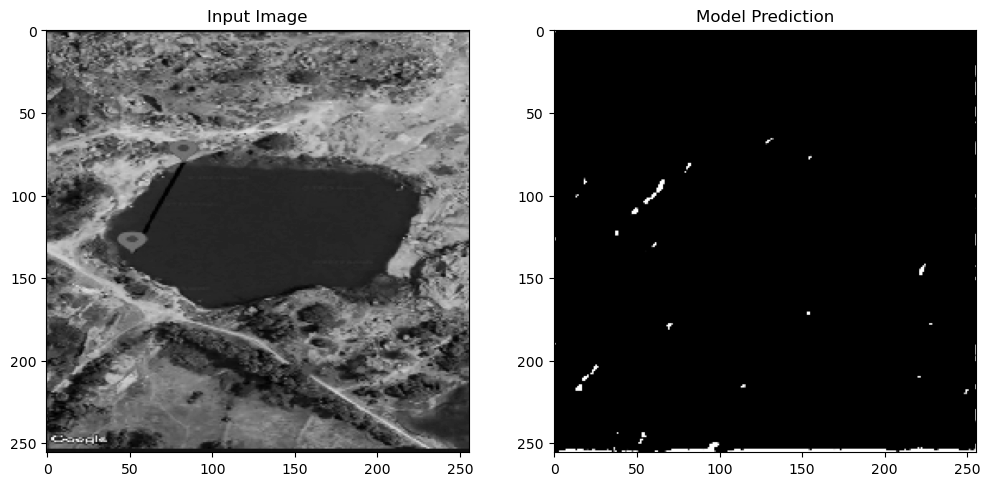

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.preprocessing import image

# Step 1: Load the saved model
model = keras.models.load_model('final.h5')

# Step 2: Load your input image
input_image_path = r"C:\Users\rokzc\jupyter\sample_sih.jpg"  # replace this with the actual path to your input image
#input_image = image.load_img(input_image_path, target_size=(256, 256), color_mode='grayscale')

# Convert the image to a numpy array
input_data = image.img_to_array(input_image)
input_data = np.expand_dims(input_data, axis=0)

# Normalize the input data if needed (depends on how the model was trained)
# input_data /= 255.0  # Uncomment and modify if your model was trained on normalized data

# Step 3: Use the model to make predictions
predictions = model.predict(input_data)

# Step 4: Visualize the input and predictions
input_image_array = input_data[0, :, :, 0]
output_image = predictions[0, :, :, 0]

plt.figure(figsize=(12, 6))

# Display the input image
plt.subplot(1, 2, 1)
plt.imshow(input_image_array, cmap='gray')
plt.title('Input Image')

# Display the predicted output
plt.subplot(1, 2, 2)
plt.imshow(output_image, cmap='gray')
plt.title('Model Prediction')

plt.show()


1/1 [==============================] - 0s 360ms/step


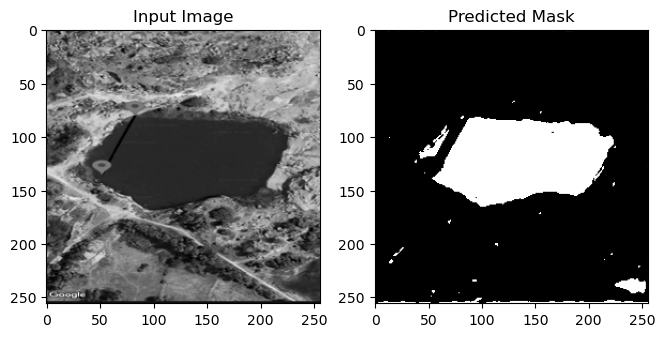

In [25]:
import numpy as np
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt

# Load the trained model from the h5 file
model = tf.keras.models.load_model('final.h5')

# Load and preprocess the input image
input_image_path =  r"C:\Users\rokzc\jupyter\sample_sih.jpg"
input_image = Image.open(input_image_path).convert('L')  # Convert to grayscale
input_image = input_image.resize((256, 256))  # Resize to match the model's input size
input_array = np.array(input_image) / 255.0  # Normalize pixel values
input_array = np.expand_dims(input_array, axis=-1)  # Add a channel dimension
input_array = np.expand_dims(input_array, axis=0)  # Add a batch dimension

# Make predictions
predicted_mask = model.predict(input_array)

# Post-process the predicted mask
threshold = 0.4  # Adjust this threshold based on your task
binary_mask = (predicted_mask > threshold).astype(np.uint8)

# Visualize the results
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_array[0, ..., 0], cmap='gray')
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(binary_mask[0, ..., 0], cmap='gray')
plt.title('Predicted Mask')

plt.show()
